# Prerequisites
All computational and statistics packages have been tested in Anaconda environment (python 3.6)
1. Install Anaconda
https://www.anaconda.com/download/#linux
2. Install Spark and Java 8
https://medium.com/@GalarnykMichael/install-spark-on-ubuntu-pyspark-231c45677de0  

***Install "pyspark"***

In [1]:
try:
    print('Trying to import pyspark...')
    import pyspark
except ImportError:
    print('Pyspark import failed...')
    print('Installing pyspark in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} pyspark

Trying to import pyspark...


***Create Spark Context***
If you enqounter any error, try to reconfigure Spark on your machine (link in the first cell - .bashrc file configuration).

In [2]:
from pyspark import SparkConf, SparkContext
try:
    sc
except NameError:
    conf = SparkConf().setAppName('SDN')
    sc = SparkContext(conf=conf)
else:
    if sc != None:
        sc.stop()
    conf = SparkConf().setAppName('SDN')
    sc = SparkContext(conf=conf)

In [3]:
# from pyspark import SparkConf, SparkContext
# conf = SparkConf().setAppName('SDN').setMaster('spark://10.0.2.15:7077').setSparkHome('/usr/local/spark/') 
# sc = SparkContext(conf=conf)

Create SQL context for spark computation.

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
from os import system
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import time
import scipy.stats as sts

from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.triggers.interval import IntervalTrigger
import matplotlib.dates as mdates
import json
import urllib
import logging, sys

Paramiko installation

In [6]:
try:
    print('Trying to import paramiko...')
    import paramiko
    print('Paramiko imported.')
except ImportError:
    print('Paramiko import failed...')
    print('Installing paramiko in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} paramiko

Trying to import paramiko...
Paramiko imported.


SCP installation

In [7]:
try:
    print('Trying to import scp...')
    import scp
    print('Scp imported.')
except ImportError:
    print('Scp import failed...')
    print('Installing scp in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} scp

Trying to import scp...
Scp imported.


Keras installation

In [8]:
try:
    print('Trying to import keras...')
    import keras
    print('Keras imported.')
except ImportError:
    print('Keras import failed...')
    print('Installing keras in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} keras

Trying to import keras...


Using TensorFlow backend.


Keras imported.


In [9]:
# keras
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import pickle

In [10]:
def loginanddownload(hostname,uname,pwd,sfile,tfile):
    """
    Can copy files and directories from PNDa to remote system.
    Usage example:
        loginanddownload(red_pnda_ip, username, password, remote_folder, local_destination)
        loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
    
    I am using it only for download full copy of /data folder from pnda VM. There is a dependency of openssh-server
    installation on red_pnda VM.
    
    """
    try:
        print("Establishing ssh connection")
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=hostname, username=uname, password=pwd)
    except paramiko.AuthenticationException:
        print("Authentication failed, please verify your credentials: %s")
    except paramiko.SSHException as sshException:
        print("Unable to establish SSH connection: %s" % sshException)
    except paramiko.BadHostKeyException as badHostKeyException:
        print("Unable to verify server's host key: %s" % badHostKeyException)
    except Exception as e:
        print(e.args)
    try:
        print("Getting SCP Client")
        scpclient = scp.SCPClient(ssh_client.get_transport())
        print("Hostname: %s", hostname)
        print("source file: %s", sfile)
        print("target file: %s", tfile)
        scpclient.get(sfile,tfile, recursive = True)
    except scp.SCPException as e:
        print("Operation error: %s", e) 

In [11]:
# load json and create model
from keras.models import model_from_json
import keras.backend as K
from sklearn.preprocessing import StandardScaler

In [12]:
class Neural_Net:
    """Neural network class which loads already learned model based on previous traffic from network.
        Based on that model we can compute uncertenity intervals. For more details plese refer to:
        http://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html"""
    
    def __init__(self, model_name, n_steps, n_length, N, l):
        """Loads model, initiates variables for uncertenity intervals computation."""
        # load model from json
        json_file = open('{}.json'.format(model_name), 'r')
        self.model = json_file.read()
        json_file.close()
        self.model = model_from_json(self.model)
        # load weights into new model
        self.model.load_weights("{}.h5".format(model_name))
        print("Loaded model from disk")
        
        """All below variables are defined based on already learned model."""
        # define probability for dropout in each layer with weight_decay 
        # and l - prior length scale, N - number of leanring samples
        self.n_steps = n_steps # number of periods on which we based our prediction
        self.n_length = n_length # period length in minutes
        self.n_input = self.n_length * self.n_steps # define the total minutes to use as input
        self.p_dense = 0.05
        self.l = l
        self.weight_decay = self.l**2/(self.n_input)
        self.N = N

        # computes tau for variance correction
        self.tau = self.l**2 * (1 - self.p_dense) / (2 * self.N * self.weight_decay)
        self.tau = self.tau**-1
        
        """For uncertanity prediction we need to approximate our nonlinear neural network
            with Gaussian Process. Training phase consisted of randomly dropping neurons from all layers
            with propability p_dense and using L2 regularization with weight_decay.
            Using random dropout on each layer we can mathematically say that our predictions are 
            almost normally distributed.
            If we want to approximate any GaussianNN we need to use dropout the same way in prediction phase
            as we used it in training phase.
            In that case we need to slightly manipulate loaded model by enabling dopout in prediction phase.
            See lines below."""
        # defines predict function from keras backend (tensorflow)
        # self.model.layers[0].input - take input shape as as it was defined in first layer
        # K.learning_phase() - if == 1 (activate droupout from learning phase)
        # self.model.layers[-1].output - produce output vector as it was defined (shape)
        self.f = K.function([self.model.layers[0].input, K.learning_phase()], [self.model.layers[-1].output])
        
        # load initial data scaler
        if 'second' in model_name:
            with open('/home/amadeusz/Documents/SDN_with_Neural_Network/scaler_sec_final.pkl', 'rb') as f:
                self.scaler = pickle.load(f)
        else:
            with open('/home/amadeusz/Documents/SDN_with_Neural_Network/scaler_final_diff_l.pkl', 'rb') as f:
                self.scaler = pickle.load(f)
        
        self.predictions = list()
        self.uncertenity = list()
        self.pred = list()
        self.unc = list()
        self.unc_up = list()
        self.unc_down = list()
    
    def predict_with_uncertainty(self, x, n_iter=10):
        result = np.zeros((n_iter,) + (x.shape[3],))

        for i in range(n_iter):
            result[i] = self.f([x, 1])[0].reshape(self.n_length)

        prediction = result.mean(axis=0)
        uncertainty = result.var(axis=0)
#         print(uncertainty)
#         uncertainty += self.tau
        return prediction, uncertainty
    
    
    def forecast(self, history):
        # standardize input data
        standardized = self.scaler.transform(history)
        # flatten data
        data = np.array(standardized)
        data = data.reshape((data.shape[0], 1))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, 0]
        # reshape into [samples, time steps, rows, cols, channels]
        input_x = input_x.reshape((1, self.n_steps, 1, self.n_length, 1))
        yhat, uncer = self.predict_with_uncertainty(input_x)
        return yhat, uncer
    
    def make_forecast(self, history):
        # reset predictions
        self.pred = list()
        self.unc = list()
        self.predictions = list()
        self.uncertenity = list()
#         history = [x for x in train]
        # predict one period
        yhat_sequence, uncert = self.forecast(history)
        # store the predictions
        self.predictions.append(yhat_sequence)
        self.uncertenity.append(uncert)
        self.predictions = np.array(self.predictions)
        self.uncertenity = np.array(self.uncertenity)
        # translate into lists
#         test_ = list()
        for i in self.predictions.reshape(self.predictions.shape[0]*self.predictions.shape[1]).tolist():
            self.pred.append(i)
        for i in self.uncertenity.reshape(self.uncertenity.shape[0]*self.uncertenity.shape[1]).tolist():
            self.unc.append(i)
            
        self.unc = np.sqrt(self.scaler.inverse_transform(np.array(self.unc))) # sigma
        
        
#         self.unc_up = self.scaler.inverse_transform(np.array(self.pred) + np.array(self.unc))
#         self.unc_down = self.scaler.inverse_transform(np.array(self.pred) - np.array(self.unc))
        
#         self.unc_up += self.tau
#         self.unc_down -= self.tau
        
        self.pred = self.scaler.inverse_transform(self.pred)
#         self.unc = self.scaler.inverse_transform(self.unc)
        
#         return self.pred, self.unc_up, self.unc_down
        return self.pred, self.unc, self.tau
#         for i in test.reshape(test.shape[0]*test.shape[1]).tolist():
#             test_.append(i)

In [13]:
class Prediction:
    """
    Prediction class - class for preprocessing data from red_pnda.
    Not full variables are in use (this is a changed copy of Lecturer shared file)
    
    Prediction class takes exacly one argument - bytes (network traffic data)
    It is further processed and returned in other format.
    
    """
    def __init__(self, bytes_, dates, network_min, network_sec):
        self.bytes = bytes_
        self.dates = dates
        self.network_min = network_min
        self.network_sec = network_sec
#         self.predictions_min = list()
#         self.uncertenity_up_min = list()
#         self.uncertenity_down_min = list()
#         self.predictions_sec = list()
#         self.uncertenity_up_sec = list()
#         self.uncertenity_down_sec = list()
        self.predictions_min = list()
        self.sigma_min = list()
        self.tau_min = None
        self.predictions_sec = list()
        self.sigma_sec = list()
        self.tau_sec = None
        
        


    def prepare_data_for_prediction(self, interval = 'minute'):
        """
        From RAW data compute time dependency (x) and bandwidth (y).
        Find mean traffic value for each minute.
        """
        self.data = self.bytes
        self.data = pd.DataFrame(data=self.data, columns=['traffic'])
        self.data = self.data.set_index(pd.DatetimeIndex(self.dates))
#         print(self.train.head())
#         print('Shape: {}'.format(self.train.shape))
        if interval == 'minute':
            self.data = self.data.groupby(pd.Grouper(freq='Min')).mean()
        elif interval == 'second':
            pass
#         print(self.train.head())
#         print('Shape: {}'.format(self.train.shape))

    def proceed_prediction(self, interval = 'min'):
        """
        Start data preprocessing.
        """
        if interval == 'minute':
            self.prepare_data_for_prediction('minute')
#             self.predictions_min, self.uncertenity_up_min, self.uncertenity_down_min = self.network_min.make_forecast([x for x in self.data.values])
            self.predictions_min, self.sigma_min, self.tau_min = self.network_min.make_forecast([x for x in self.data.values])

        elif interval == 'second':
            self.prepare_data_for_prediction('second')
#             self.predictions_sec, self.uncertenity_up_sec, self.uncertenity_down_sec = self.network_sec.make_forecast([x for x in self.data.values])
            self.predictions_sec, self.sigma_sec, self.tau_sec = self.network_sec.make_forecast([x for x in self.data.values])


In [63]:
class WatchDog:
    """
    WatchDog class - extracts bandwidth information from collected flow and port data.
    (Not all variables are in use)
    
    self.dpid - particular switch identification number
    self.port_no - particular port number on the switch
    """
    def __init__(self, data_path):    
        self.interval = 60 # co ile sekund sprawdzam czy nie ma anomalii
        self.network_min = None
        self.network_sec = None
        self.unusual = 0
        self.normal_work = True
        self.train_data = None
        self.pred = None
        self.pi = None
        self.current_stats = None
#         self.sched = BackgroundScheduler()
#         self.sched.start()
        self.dpid = 2
        self.port_no = 2
        self.resampled = None
        self.data_path = data_path
        
    def get_last_hour_stats(self):
        """
        Currently not in use.
        """
        last_hour_time = datetime.now() - timedelta(hours = 1)
        year = int(last_hour_time.strftime("%Y"))
        month = int(last_hour_time.strftime("%m"))
        day = int(last_hour_time.strftime("%d"))
        hour = int(last_hour_time.strftime("%H"))
        self.train_data = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                             "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
        
    def get_previous_stats(self):
        """
        Gather statistics from particular hour/day.
        You can change dates based on your gathered data.
        """
#         year="2019"
#         month="1"
#         day="4"
#         hour=0
        year = int(time.strftime("%Y"))
        month = int(time.strftime("%m"))
        day = int(time.strftime("%d")) - 5
        hour = int(time.strftime("%H"))
        roznica = 0
        d = list()
        if hour - 5 < 0: # jezeli 5 godzin temu to byl inny dzien
            day -= 1 # zmien dzien na wczoraj
            roznica = np.abs(hour - 5) # policz roznice w godzinach
            hour = 24 + (hour - 5) # policz godzine jaka byla 5 godzin temu, skaluj do wczorajszej 24-ki
            # pobierz dane z konkretnej godziny wczoraj
            data = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                            "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
            for i in range(1,roznica): # pobieraj dane do konca wczorajszego dnia
                h = hour + i
                d.append(sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                                  "/day="+str(day)+"/hour="+str(h)+"/dump.json"))
#                 print('h = {}'.format(h))

            for i in range(int(time.strftime("%H"))+1): # pobieraj dane od polnocy do biezacej godziny
                h = i
                d.append(sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                                  "/day="+str(day+1)+"/hour="+str(h)+"/dump.json"))
#                 print('h = {}'.format(h))
        else: # jezeli 5 godzin temu nadal bylo dzisiaj
            hour -= 5 # cofnij sie o 5 godzin i pobierz dane
            data = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                            "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
            for i in range(hour+1, int(time.strftime("%H"))+1): # pobieraj dane do biezacej godziny
                h = i
                d.append(sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                                  "/day="+str(day)+"/hour="+str(h)+"/dump.json"))
#             print(d[1])

        # zcal wszystkie pobrane dane z 5-6 godzin
        for i in range(0,len(d)):
            data = data.unionAll(d[i])            
        self.train_data = data
        
        return hour
    
    def get_current_stats(self):
        """
        Currently not in use.
        """
        year = int(time.strftime("%Y"))
        month = int(time.strftime("%m"))
        day = int(time.strftime("%d")) - 5 # do usuniecia 2 !!!!!!!!!!!!!!!!!!!!!!!
        hour = int(time.strftime("%H"))
        loginanddownload('192.168.57.5', 'pnda', 'pnda', '/data/year={}/month={}/day={}/hour={}/'.format(year, 
                                                                                                         month, 
                                                                                                         day,
                                                                                                         hour),
                         '/home/amadeusz/data/year={}/month={}/day={}/'.format(year, 
                                                                               month, 
                                                                               day, 
                                                                               hour))
        
        self.current_stats = sqlContext.read.json(self.data_path+"data/year="+str(year)+"/month="+str(month)+
                                             "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
#         self.current_stats = sqlContext.read.json("data/year="+str(year)+"/month="+str(month)+
#                                              "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
    
    def get_port_stats(self,data,dpid,port_no):
        """
        Gathers data from specific port on the switch.
        """
        port = data.filter((data['origin']=='port_stats') & 
                           (data['switch_id']==dpid) & 
                           (data['port_no']==port_no)).orderBy('timestamp')
        port = port.toPandas()
        ts = pd.Series(port['timestamp'].astype(int))
        ts = pd.to_datetime(ts, unit='s')
        index = pd.DatetimeIndex(ts)
        raw_data = pd.Series(port['tx_bytes'].values, index=index)
        return raw_data, port
    
    def get_last_tput(self, dpid, port_no, interval):
        """
        Pobieram minute ostatniego ruchu do analizy
        """
        if interval == 'minute':
            # pobieram 13 ostatnich probek (jedna probka co 5 secund czyli chce miec 60 sekund ruchu)
            last_minute = self.current_stats.filter((self.current_stats['origin']=='port_stats') & 
                               (self.current_stats['switch_id']==dpid) & 
                               (self.current_stats['port_no']==port_no)).orderBy('timestamp', ascending=False).limit(13)
            last_minute = last_minute.toPandas()
            bytes_ = last_minute['tx_bytes'].astype(int)
            time_ = last_minute['timestamp'].astype(int)
            tput = (bytes_[0]-bytes_.iloc[-1])/(time_[0]-time_.iloc[-1]) # licze roznice w ruchu jaki byl 60s temu i teraz i dziele przez czas
        elif interval == 'second':
            # pobieram 2 ostatnie probki (jedna probka co 5 secund czyli chce miec 5 sekund ruchu, wyciagam srednia na sekunde)
            last_minute = self.current_stats.filter((self.current_stats['origin']=='port_stats') & 
                               (self.current_stats['switch_id']==dpid) & 
                               (self.current_stats['port_no']==port_no)).orderBy('timestamp', ascending=False).limit(2)
            last_minute = last_minute.toPandas()
            bytes_ = last_minute['tx_bytes'].astype(int)
            time_ = last_minute['timestamp'].astype(int)
            tput = (bytes_[0]-bytes_.iloc[-1])/(time_[0]-time_.iloc[-1]) # licze roznice w ruchu jaki byl w czasie 2s
       
        return tput*8/1e6 #Mbps (licze/zamieniam na Mbps)
        
    def resample_port_stats (self,raw_data, port, start):
        """
        Resamples data into correct date format and frequency.
        """
        raw_data = raw_data[~raw_data.index.duplicated(keep='first')]
        resampled_data = raw_data.resample('s').interpolate()
        resampled_data = [(y - x) for x,y in zip(resampled_data.values,resampled_data.values[1:])]
        ts_resampled = pd.Series(range(len(resampled_data))) + start*60*60
        ts_resampled= pd.to_datetime(ts_resampled, unit='s')
        return resampled_data, ts_resampled
    
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def check_current_traffic(self, mode):
#         loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
        hour = int(time.strftime("%H"))
        minute = int(time.strftime("%M"))
        second = int(time.strftime("%S"))
        if mode == 'minute':

            # upper and lower limits for minute prediction
            up_min = self.pred_check_data_min.loc[(self.pred_check_data_min['hour'] == hour) & 
                                                  (self.pred_check_data_min['minute'] == minute)]['up'].values[0]
            down_min = self.pred_check_data_min.loc[(self.pred_check_data_min['hour'] == hour) & 
                                                    (self.pred_check_data_min['minute'] == minute)]['down'].values[0]
            print('up: {}'.format(up_min))
            print('down: {}'.format(down_min))
            self.get_current_stats() # pobierz dane z teraz
            cur_tput_min = self.get_last_tput(self.dpid, self.port_no, 'minute') # wyodrebnij tylko dane z danego portu na switchu
            _ = system('clear') 
            print('tput = {}'.format(cur_tput_min))
            if cur_tput_min > up_min or cur_tput_min < down_min:
                print('Anomaly detected!!! (minutes interval)')
                self.normal_work = False
            else:
                print('Normal traffic... (minutes interval)')
                self.normal_work = True
        elif mode == 'second':
            # upper and lower limits for second prediction
            up_sec = self.pred_check_data_sec.loc[(self.pred_check_data_sec['hour'] == hour) & 
                                                  (self.pred_check_data_sec['minute'] == minute) &
                                                  (pred_check_data_sec['second'] == second)]['up'].values[0]
            down_sec = self.pred_check_data_sec.loc[(self.pred_check_data_sec['hour'] == hour) & 
                                                    (self.pred_check_data_sec['minute'] == minute) &
                                                    (pred_check_data_sec['second'] == second)]['down'].values[0]

            print('up: {}'.format(up_sec))
            print('down: {}'.format(down_sec))
            self.get_current_stats() # pobierz dane z teraz
            cur_tput_sec = self.get_last_tput(self.dpid, self.port_no, 'second') # wyodrebnij tylko dane z danego portu na switchu
            _ = system('clear') 
            print('tput = {}'.format(cur_tput_sec))
            if (cur_tput_sec > up_sec or cur_tput_sec < down_sec):
                self.unusual += 1
                if self.unusual >= 50:
                    print('Anomaly detected!!! (seconds interval)')
                    self.normal_work = False
            else:
                self.unusual = 0
                print('Normal traffic... (seconds interval)')
                self.normal_work = True
        
            
#         if self.unusual > 2 and self.normal_work == True:
#             self.change_interval(5)
#             self.normal_work = False
#             print('changing interval to 5s')
#         elif self.unusual == 0 and self.normal_work == False:
#             self.change_interval(300)
#             self.normal_work = True
#             print('changing interval to 300s')
            
    # wystartuj observer i monitoruj/zmieniaj interval ??
    def start_stats_observer(self):
        self.sched.add_job(self.check_current_traffic, 'interval', seconds=self.interval)

    def change_job_interval(self,interval):
        print("Rescheduling stat request to %i seconds", interval)
        for s in self.sched.get_jobs():
            print('rescheduling job %s', s.id)
            it = IntervalTrigger(seconds=interval)
            self.sched.reschedule_job(s.id, trigger=it)

    def change_interval(self, interval):
        print("changing interval to %i" % interval)
        self.send_stats_interval(interval)
        self.change_job_interval(interval)
        
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    
    
    
    def proceed_prediction(self, enable_plot, mode, plot_prediction):
        """
        Start preprocessing traffic data.
        
        If you want to download data to your localhost just uncomment first line.
        This is not necessary when you have all the data stored locally already.
        """
#         loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
        year = int(time.strftime("%Y"))
        month = int(time.strftime("%m"))
        day = int(time.strftime("%d"))
#         loginanddownload('192.168.57.5', 'pnda', 'pnda', '/data/year={}/month={}/day={}/'.format(year, month, day),
#                          '/home/amadeusz/data/year={}/month={}/'.format(year, month, day))
#         self.get_current_stats()
        if self.network_min is None and self.network_sec is None:
            self.network_min = Neural_Net('/home/amadeusz/Documents/SDN_with_Neural_Network/model_standardise_with_l_higher_wd_bayasian_RNN', 10, 30, 1440*6, 1e-1) # loads neural network model minutes
            self.network_sec = Neural_Net('/home/amadeusz/Documents/SDN_with_Neural_Network/model_standardise_seconds_l_bayasian_RNN', 10, 60, 86400, 1e-1) # loads neural network model seconds
        
        start = self.get_previous_stats() # pobierz 5 godzin ruchu od teraz wstecz
        data, port_stats = self.get_port_stats(self.train_data, self.dpid, self.port_no) # wydziel ruch z danego portu
        resampled_data, ts_resampled = self.resample_port_stats(data, port_stats, start) # przygotuj dane
        
        # test (jezeli robie bez wlaczonej kafki, musze usunac dopelnienie do godziny ruchu bo mam juz pobrany)
        minute = 60 - int(time.strftime("%M"))
        resampled_data = resampled_data[:-minute*60]
        ts_resampled = ts_resampled[:-minute*60]
    
        self.ts_resampled = ts_resampled # store time vector
        self.resampled = [x*8/1e6 for x in resampled_data] # zamien na Mbps (nadal w przedzialach sekundowych)

        prediction = Prediction(self.resampled, ts_resampled, self.network_min, self.network_sec) # prepare data for prediction
        if mode == 'minute':
            prediction.proceed_prediction('minute') # make 30 minutes prediction
        elif mode == 'second':
            prediction.proceed_prediction('second') # make 60 seconds prediction
        
        # plotting part (plots 5 hours back and predicted mean with uncertenity)
        if enable_plot:
            if mode == 'minute':
#                 fig = plt.figure(figsize=(15,8))
#                 ax = fig.add_subplot(111)
                # resample 5 hour data from seconds into minutes
                ixy = pd.DataFrame(data=[x*8/1e6 for x in resampled_data], columns=['traffic'])
                ixy = ixy.set_index(pd.DatetimeIndex(ts_resampled))
                ixy = ixy.groupby(pd.Grouper(freq='Min')).mean()
                # 
                new_pred = prediction.predictions_min.tolist()
#                 new_unc_up = prediction.uncertenity_up_min.tolist()
#                 new_unc_down = prediction.uncertenity_down_min.tolist()
                new_sigma_min = prediction.sigma_min.tolist()
                for position, i in enumerate(ixy.values.tolist()):
                    new_pred.insert(position,i[0])
#                     new_unc_up.insert(position,i[0])
#                     new_unc_down.insert(position,i[0])
                    new_sigma_min.insert(position,i[0])
                # creates datetime range for plots
                if self.ts_resampled.iloc[-1].minute + 30 < 60:
                    x1 = pd.date_range(start='{}-{}-{} {}:{}:00'.format(self.ts_resampled.iloc[0].year,
                                                                       self.ts_resampled.iloc[0].month,
                                                                       self.ts_resampled.iloc[0].day,
                                                                       self.ts_resampled.iloc[0].hour,
                                                                       self.ts_resampled.iloc[0].minute), 
                                      end='{}-{}-{} {}:{}:00'.format(self.ts_resampled.iloc[-1].year,
                                                                     self.ts_resampled.iloc[-1].month,
                                                                     self.ts_resampled.iloc[-1].day,
                                                                     self.ts_resampled.iloc[-1].hour,
                                                                     self.ts_resampled.iloc[-1].minute+30), 
                                      freq="1min")
                else:
                    print('jednak tutaj weszlo')
                    if self.ts_resampled.iloc[-1].hour+1 >= 24:
                        hour = 0
                        day = self.ts_resampled.iloc[-1].day + 1
                    else:
                        hour = self.ts_resampled.iloc[-1].hour+1
                        day = self.ts_resampled.iloc[-1].day
                    x1 = pd.date_range(start='{}-{}-{} {}:{}:00'.format(self.ts_resampled.iloc[0].year,
                                                                       self.ts_resampled.iloc[0].month,
                                                                       self.ts_resampled.iloc[0].day,
                                                                       self.ts_resampled.iloc[0].hour,
                                                                       self.ts_resampled.iloc[0].minute), 
                                      end='{}-{}-{} {}:{}:00'.format(self.ts_resampled.iloc[-1].year,
                                                                     self.ts_resampled.iloc[-1].month,
                                                                     day,
                                                                     hour,
                                                                     (self.ts_resampled.iloc[-1].minute+30) - 60), 
                                      freq="1min")
                x2 = pd.date_range(start='{}'.format(self.ts_resampled.iloc[0]), 
                                      end='{}'.format(self.ts_resampled.iloc[-1]), 
                                      freq="1min")

                self.pred_check_data_min = pd.DataFrame(data=np.zeros(len(new_sigma_min)), 
                                                    columns=['zeros'])

#                 self.pred_check_data_min['up'] = new_unc_up
#                 self.pred_check_data_min['down'] = new_unc_down
                self.pred_check_data_min['sigma'] = new_sigma_min
                self.pred_check_data_min['hour'] = [p.hour for p in pd.to_datetime(x1)]
                self.pred_check_data_min['minute'] = [p.minute for p in pd.to_datetime(x1)]
                
                if plot_prediction:
#                     ax.plot(x1, new_pred, 'g') # plot prediction mean
#                     ax.fill_between(x1, new_unc_up, new_unc_down, facecolor='yellow') # plot prediction uncertenity interval
                    
                    new_pred = prediction.predictions_min.tolist()
                    new_sigma_min = prediction.sigma_min.tolist()
                    new_4sigma_min_up = np.asarray(new_pred) + (np.asarray(new_sigma_min) + prediction.tau_min)*4
                    new_4sigma_min_up = new_4sigma_min_up.tolist()
                    new_4sigma_min_down = np.asarray(new_pred) - (np.asarray(new_sigma_min) + prediction.tau_min)*4
                    new_4sigma_min_down = new_4sigma_min_down.tolist()
                    new_3sigma_min_up = np.asarray(new_pred) + (np.asarray(new_sigma_min) + prediction.tau_min)*3
                    new_3sigma_min_up = new_3sigma_min_up.tolist()
                    new_3sigma_min_down = np.asarray(new_pred) - (np.asarray(new_sigma_min) + prediction.tau_min)*3
                    new_3sigma_min_down = new_3sigma_min_down.tolist()
                    new_sigma_min_up = np.asarray(new_pred) + (np.asarray(new_sigma_min) + prediction.tau_min)
                    new_sigma_min_up = new_sigma_min_up.tolist()
                    new_sigma_min_down = np.asarray(new_pred) - (np.asarray(new_sigma_min) + prediction.tau_min)
                    new_sigma_min_down = new_sigma_min_down.tolist()
                    
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    ax.plot(x1[-len(new_pred):], new_pred, 'g', label = 'predicted mean') # plot prediction mean
                    # 4*sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_4sigma_min_up, 
                                    new_4sigma_min_down, 
                                    facecolor='red', 
                                    alpha=0.2,
                                    label = '4 sigma')
                    # 3*sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_3sigma_min_up, 
                                    new_3sigma_min_down, 
                                    facecolor='red', 
                                    alpha=0.4,
                                    label = '3 sigma')
                    # sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_sigma_min_up, 
                                    new_sigma_min_down, 
                                    facecolor='red', 
                                    alpha=0.7,
                                    label = 'sigma')
                    ax.legend()
                    ax.set_title('Predicted 30 minutes with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                    ax.set_xlabel('hour:min')
                    ax.set_ylim(bottom = 0)
                    
                    for position, i in enumerate(ixy.values.tolist()):
                        new_pred.insert(position,i[0])
                        new_4sigma_min_up.insert(position,i[0])
                        new_4sigma_min_down.insert(position,i[0])
                        new_3sigma_min_up.insert(position,i[0])
                        new_3sigma_min_down.insert(position,i[0])
                        new_sigma_min_up.insert(position,i[0])
                        new_sigma_min_down.insert(position,i[0])
                        
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                        
                    ax.plot(x1, new_pred, 'g', label = 'predicted mean') # plot prediction mean
                    # 4*sigma
                    ax.fill_between(x1, 
                                    new_4sigma_min_up, 
                                    new_4sigma_min_down, 
                                    facecolor='red', alpha=0.2, label = '4 sigma')
                    # 3*sigma
                    ax.fill_between(x1, 
                                    new_3sigma_min_up, 
                                    new_3sigma_min_down, 
                                    facecolor='red', alpha=0.4, label = '3 sigma')
                    # sigma
                    ax.fill_between(x1, 
                                    new_sigma_min_up, 
                                    new_sigma_min_down, 
                                    facecolor='red', alpha=0.7, label = 'sigma')
                    
                    ax.plot(x2, ixy.values, 'b', label = 'known values') # plot 5 hours back
                    ax.legend(loc = 'upper left')
                    ax.set_title('5 hours traffic and predicted 30 min with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                    ax.set_xlabel('hour:min')
                    ax.set_ylim(bottom = 0)
                else:
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    ax.plot(x2, ixy.values, 'b', label = 'known values') # plot 5 hours back
                    ax.legend(loc = 'upper left')
                    ax.set_title('5 hours traffic and predicted 30 min with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                    ax.set_xlabel('hour:min')
                    ax.set_ylim(bottom = 0)
                
            elif mode == 'second':
                # seconds part
#                 fig = plt.figure(figsize=(15,8))
#                 ax = fig.add_subplot(111)
                # resample 5 hour data from seconds into minutes
                ixy = pd.DataFrame(data=[x*8/1e6 for x in resampled_data][-600:], columns=['traffic'])
                ixy = ixy.set_index(pd.DatetimeIndex(ts_resampled[-600:]))
                # 
                new_pred = prediction.predictions_sec.tolist()
#                 new_unc_up = prediction.uncertenity_up_sec.tolist()
#                 new_unc_down = prediction.uncertenity_down_sec.tolist()
                new_sigma_sec = prediction.sigma_sec.tolist()
                for position, i in enumerate(ixy.values.tolist()):
                    new_pred.insert(position,i[0])
#                     new_unc_up.insert(position,i[0])
#                     new_unc_down.insert(position,i[0])
                    new_sigma_sec.insert(position,i[0])
                # creates datetime range for plots
                if self.ts_resampled.iloc[-1].minute + 1 < 60:
                    x1 = pd.date_range(start='{}-{}-{} {}:{}:{}'.format(self.ts_resampled.iloc[-600].year,
                                                                       self.ts_resampled.iloc[-600].month,
                                                                       self.ts_resampled.iloc[-600].day,
                                                                       self.ts_resampled.iloc[-600].hour,
                                                                       self.ts_resampled.iloc[-600].minute,
                                                                       self.ts_resampled.iloc[-600].second), 
                                      end='{}-{}-{} {}:{}:{}'.format(self.ts_resampled.iloc[-1].year,
                                                                     self.ts_resampled.iloc[-1].month,
                                                                     self.ts_resampled.iloc[-1].day,
                                                                     self.ts_resampled.iloc[-1].hour,
                                                                     self.ts_resampled.iloc[-1].minute+1,
                                                                     self.ts_resampled.iloc[-1].second), 
                                      freq="1S")
                else:
                    print('jednak tutaj weszlo')
                    if self.ts_resampled.iloc[-1].hour+1 >= 24:
                        hour = 0
                        day = self.ts_resampled.iloc[-1].day + 1
                    else:
                        hour = self.ts_resampled.iloc[-1].hour+1
                        day = self.ts_resampled.iloc[-1].day
                    x1 = pd.date_range(start='{}-{}-{} {}:{}:{}'.format(self.ts_resampled.iloc[-600].year,
                                                                       self.ts_resampled.iloc[-600].month,
                                                                       self.ts_resampled.iloc[-600].day,
                                                                       self.ts_resampled.iloc[-600].hour,
                                                                       self.ts_resampled.iloc[-600].minute,
                                                                       self.ts_resampled.iloc[-600].second), 
                                      end='{}-{}-{} {}:{}:{}'.format(self.ts_resampled.iloc[-1].year,
                                                                     self.ts_resampled.iloc[-1].month,
                                                                     day,
                                                                     hour,
                                                                     '00',
                                                                     self.ts_resampled.iloc[-1].second), 
                                      freq="1S")
                x2 = pd.date_range(start='{}'.format(self.ts_resampled.iloc[-600]), 
                                      end='{}'.format(self.ts_resampled.iloc[-1]), 
                                      freq="1S")

                self.pred_check_data_sec = pd.DataFrame(data=np.zeros(len(new_sigma_sec)), 
                                                    columns=['zeros'])

#                 self.pred_check_data_sec['up'] = new_unc_up
#                 self.pred_check_data_sec['down'] = new_unc_down
                self.pred_check_data_sec['sigma'] = new_sigma_sec
                self.pred_check_data_sec['hour'] = [p.hour for p in pd.to_datetime(x1)]
                self.pred_check_data_sec['minute'] = [p.minute for p in pd.to_datetime(x1)]
                self.pred_check_data_sec['second'] = [p.second for p in pd.to_datetime(x1)]
                
                if plot_prediction:
                    new_pred = prediction.predictions_sec.tolist()
                    new_sigma_sec = prediction.sigma_sec.tolist()
                    new_4sigma_sec_up = np.asarray(new_pred) + (np.asarray(new_sigma_sec) + prediction.tau_sec)*4
                    new_4sigma_sec_up = new_4sigma_sec_up.tolist()
                    new_4sigma_sec_down = np.asarray(new_pred) - (np.asarray(new_sigma_sec) + prediction.tau_sec)*4
                    new_4sigma_sec_down = new_4sigma_sec_down.tolist()
                    new_3sigma_sec_up = np.asarray(new_pred) + (np.asarray(new_sigma_sec) + prediction.tau_sec)*3
                    new_3sigma_sec_up = new_3sigma_sec_up.tolist()
                    new_3sigma_sec_down = np.asarray(new_pred) - (np.asarray(new_sigma_sec) + prediction.tau_sec)*3
                    new_3sigma_sec_down = new_3sigma_sec_down.tolist()
                    new_sigma_sec_up = np.asarray(new_pred) + (np.asarray(new_sigma_sec) + prediction.tau_sec)
                    new_sigma_sec_up = new_sigma_sec_up.tolist()
                    new_sigma_sec_down = np.asarray(new_pred) - (np.asarray(new_sigma_sec) + prediction.tau_sec)
                    new_sigma_sec_down = new_sigma_sec_down.tolist()
                    
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    ax.plot(x1[-len(new_pred):], new_pred, 'g', label = 'predicted mean') # plot prediction mean
                    # 4*sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_4sigma_sec_up, 
                                    new_4sigma_sec_down, 
                                    facecolor='red', 
                                    alpha=0.2,
                                    label = '4 sigma')
                    # 3*sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_3sigma_sec_up, 
                                    new_3sigma_sec_down, 
                                    facecolor='red', 
                                    alpha=0.4,
                                    label = '3 sigma')
                    # sigma
                    ax.fill_between(x1[-len(new_pred):], 
                                    new_sigma_sec_up, 
                                    new_sigma_sec_down, 
                                    facecolor='red', 
                                    alpha=0.7,
                                    label = 'sigma')
                    ax.legend()
                    ax.set_title('Predicted 60 seconds with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
                    ax.set_xlabel('min:sec')
                    ax.set_ylim(bottom = 0)
                    
                    for position, i in enumerate(ixy.values.tolist()):
                        new_pred.insert(position,i[0])
                        new_4sigma_sec_up.insert(position,i[0])
                        new_4sigma_sec_down.insert(position,i[0])
                        new_3sigma_sec_up.insert(position,i[0])
                        new_3sigma_sec_down.insert(position,i[0])
                        new_sigma_sec_up.insert(position,i[0])
                        new_sigma_sec_down.insert(position,i[0])
                        
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    
                    
                    ax.plot(x1, new_pred, 'g', label = 'predicted mean') # plot prediction mean
#                     ax.fill_between(x1, new_unc_up, new_unc_down, facecolor='yellow') # plot prediction uncertenity interval
                    # 4*sigma
                    ax.fill_between(x1, 
                                    new_4sigma_sec_up, 
                                    new_4sigma_sec_down, 
                                    facecolor='red', alpha=0.2, label = '4 sigma')
                    # 3*sigma
                    ax.fill_between(x1, 
                                    new_3sigma_sec_up, 
                                    new_3sigma_sec_down, 
                                    facecolor='red', alpha=0.4, label = '3 sigma')
                    # sigma
                    ax.fill_between(x1, 
                                    new_sigma_sec_up, 
                                    new_sigma_sec_down, 
                                    facecolor='red', alpha=0.7, label = 'sigma')
                    ax.plot(x2, ixy.values, 'b', label = 'known values') # plot 5 hours back
                    ax.legend(loc = 'upper left')
                    ax.set_title('600 seconds traffic and predicted 60 sec with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
                    ax.set_xlabel('min:sec')
                    ax.set_ylim(bottom = 0)
                else:
                    fig = plt.figure(figsize=(15,8))
                    ax = fig.add_subplot(111)
                    ax.plot(x2, ixy.values, 'b', label = 'known values') # plot 5 hours back
                    ax.legend(loc = 'upper left')
                    ax.set_title('600 seconds traffic and predicted 60 sec with uncertenity intervals.')
                    ax.set_ylabel("Tput [Mbps]")
                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
                    ax.set_xlabel('min:sec')
                    ax.set_ylim(bottom = 0)

In [ ]:
wd.ts_resampled.tail()

In [ ]:
wd = WatchDog("/home/amadeusz/")
wd.check_current_traffic()

***Load the data***
Preprocessed data will be stored in wd.resampled

In [36]:
loginanddownload('192.168.57.5', 'pnda', 'pnda', '/data', '/home/amadeusz/')

Establishing ssh connection
Getting SCP Client
Hostname: %s 192.168.57.5
source file: %s /data
target file: %s /home/amadeusz/


DataFrame[byte_count: bigint, dst_mac: string, duration_nsec: bigint, duration_sec: bigint, in_port: bigint, origin: string, packet_count: bigint, port_no: bigint, rx_bytes: bigint, rx_errors: bigint, rx_packets: bigint, src_mac: string, switch_id: bigint, timestamp: double, tx_bytes: bigint, tx_errors: bigint, tx_packets: bigint]
1.9630537033081055
DataFrame[byte_count: bigint, dst_mac: string, duration_nsec: bigint, duration_sec: bigint, in_port: bigint, origin: string, packet_count: bigint, port_no: bigint, rx_bytes: bigint, rx_errors: bigint, rx_packets: bigint, src_mac: string, switch_id: bigint, timestamp: double, tx_bytes: bigint, tx_errors: bigint, tx_packets: bigint]
2.81048583984375


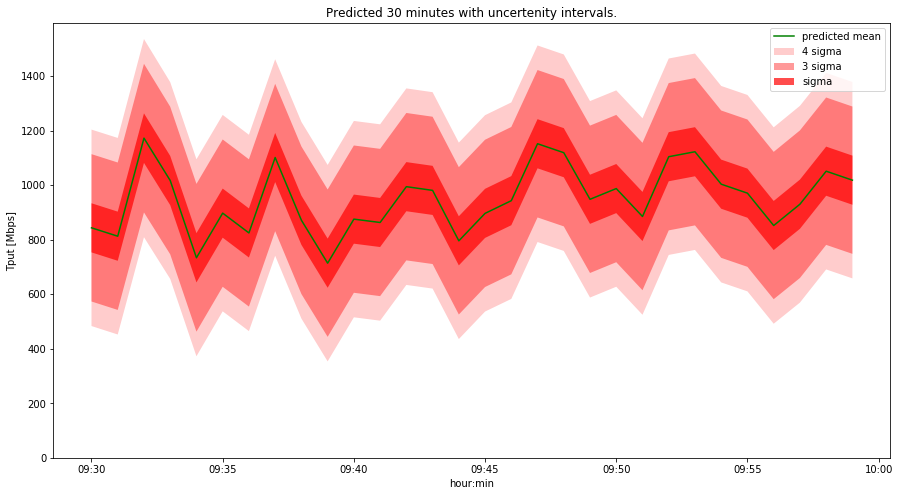

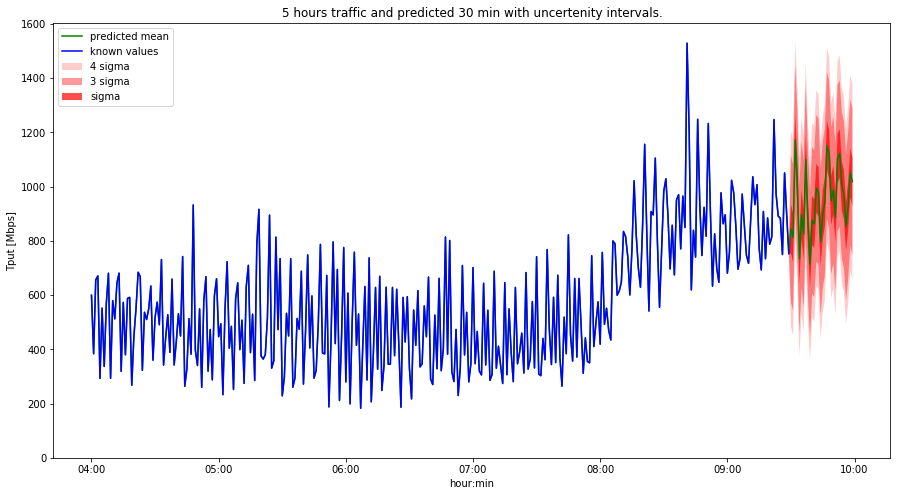

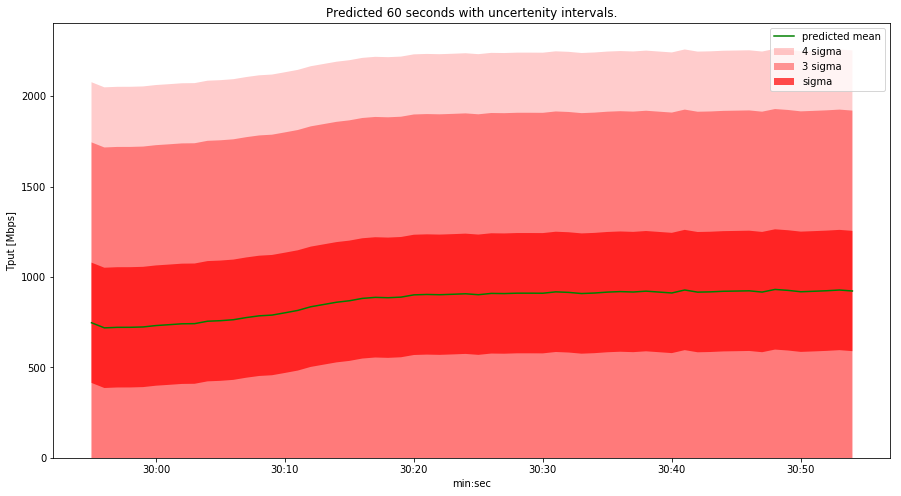

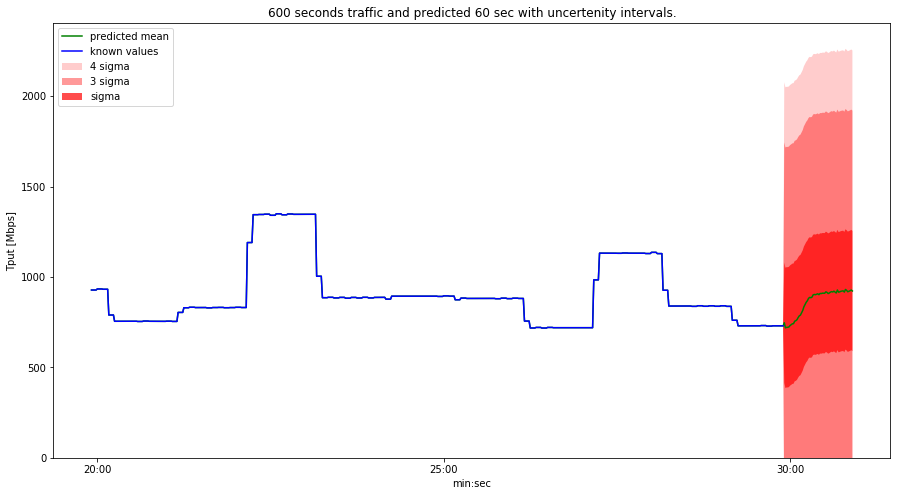

In [62]:
# please specify path to data folder
# %matplotlib inline
# wd = WatchDog("/home/amadeusz/")
start = time.time()
wd.proceed_prediction(enable_plot = True, mode = 'minute', plot_prediction = True)
end = time.time()
print(end-start)
start = time.time()
wd.proceed_prediction(enable_plot = True, mode = 'second', plot_prediction = True)
end = time.time()
print(end-start)

In [ ]:
# Here you have preprocessed traffic data stored in var series. Data is in Mbps.
series = [x*8/1e6 for x in wd.resampled]

In [ ]:
for i in range(100):
    wd.check_current_traffic()
    time.sleep(60)

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=n_lag, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.6))
    model.add(Dense(8, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.6))
    model.add(Dense(n_seq, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.figure(figsize=(15,8))
    plt.plot(series)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')

# load dataset
series = series = [x*8/1e6 for x in wd.resampled]
# configure
n_lag = 100
n_seq = 100
n_test = 10000
n_epochs = 40
n_batch = 1000
n_neurons = 64
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = wider_model()
# evaluate model with standardized dataset
history = model.fit(train[:,0:-n_seq], train[:,-n_seq:], epochs=40, batch_size=1000, verbose=1)
# Predict test dataset without confidence interval
forecasts = model.predict(test[:,0:-n_seq], batch_size=1000)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[-n_seq:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# # plot forecasts
plot_forecasts(series, forecasts, n_test+2)

# Simple Neural Network part (only one step ahead prediction)

In [ ]:
# frame a sequence as a supervised learning problem
# def timeseries_to_supervised(data, lag=1):
#     df = pd.DataFrame(data)
#     columns = [df.shift(i) for i in range(1, lag+1)]
#     columns.append(df)
#     df = pd.concat(columns, axis=1)
#     df.fillna(0, inplace=True)
#     return df



# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


 
# # create a differenced series
# def difference(dataset, interval=1):
#     diff = list()
#     for i in range(interval, len(dataset)):
#         value = dataset[i] - dataset[i - interval]
#         diff.append(value)
#     return pd.Series(diff)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# load dataset
series = [x*8/1e6 for x in wd.resampled]

# transform data to be stationary
diff_values = difference(series, 1)
 
# rescale values to -1, 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
diff_values = diff_values.values
diff_values = diff_values.reshape(len(diff_values), 1)
scaled_values = scaler.fit_transform(diff_values)   

# transform data to be supervised learning
# supervised = timeseries_to_supervised(diff_values, 100)
n_lag = 10
n_seq = 3
supervised = series_to_supervised(diff_values.tolist(), n_lag, n_seq)
supervised_values = supervised.values
 
# # split data into train and test-sets
# train, test = supervised_values[0:-2000], supervised_values[-2000:]
 
# # transform the scale of the data
# scaler, train_scaled, test_scaled = scale(train, test)
train_scaled, test_scaled = supervised_values[0:-2000], supervised_values[-2000:]

In [ ]:
scaled_values.shape

In [ ]:
train_scaled.shape

In [ ]:
test_scaled.shape

***Create NN model in Keras***

In [ ]:
from keras.layers import Dropout
from keras.constraints import maxnorm
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=n_lag, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.6))
    model.add(Dense(8, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.6))
    model.add(Dense(n_seq, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model = wider_model()
model.summary()

In [ ]:
# evaluate model with standardized dataset
history = model.fit(train_scaled[:,0:-n_seq], train_scaled[:,-n_seq:], epochs=40, batch_size=1000, verbose=1)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('Number of epochs')

In [ ]:
# Predict test dataset without confidence interval
predictions = model.predict(test_scaled[:,0:-n_seq], batch_size=1000)

In [ ]:
predictions.shape

In [ ]:
series[0]

In [ ]:
# inverse data transform on forecasts
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
inverted = inverse_transform(series, predictions, scaler, 2000)

In [ ]:
len(inverted)# inverse transform forecasts and test
forecasts = inverse_transform(series, predictions, scaler, 2000+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, 2000+2)

In [ ]:
# invert scaling, differencing
pred = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-n_seq], test_scaled[i, -n_seq:]
    # invert scaling
    yhat = invert_scale(scaler, X, predictions[i])
    # invert differencing
    yhat = inverse_difference(series, yhat, len(test_scaled)+1-i)
    # store forecast
    pred.append(yhat)
    expected = series[len(train) + i + 1]

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(series[-2000:], 'b')
plt.plot(inverted, 'r.')

In [ ]:
# performance 
rmse = np.sqrt(mean_squared_error(series[-2000:-1], pred[1:]))
print('Test RMSE: %.3f' % rmse)

***Prediction with confidence interval***  
https://stackoverflow.com/questions/43529931/how-to-calculate-prediction-uncertainty-using-keras  
http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html#uncertainty-sense  
https://www.reddit.com/r/deepfeec/comments/4bjwx7/plano_de_ataque_redes_neurais_bayesianas_resolvem/

In [ ]:
# create tensorflow function to apply dropout during prediction
import keras.backend as K
f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

In [ ]:
def predict_with_uncertainty(f, x, n_iter=200):
    """
    All below computation based on couple variables:
    l - prior length-scale, this captures our belief over the function frequency.
        A short length-scale l corresponds to high frequency data, and a long length-scale
        corresponds to low frequency data (choosen experimentally, I cannot confirm if this variable
        is good for this problem)
    N - number of training samples
    w_d - weight_decay (originally it was model.weight_decay but keras sequential model does not have this attribute
            and along with my understending it is just a regularization), in this situation we have Dropout
            regularization so this variable is also set experimentally, there should be further explenation
    """
    result = np.zeros((n_iter,) + x.shape)

    for iter in range(n_iter):
        result[iter] = f([np.asmatrix(x).reshape(2000,1), 1])[0][:,0]
        pred_1 = list()
        for i in range(len(result[iter])):
            # make one-step forecast
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            # invert scaling
            yhat = invert_scale(scaler, X, result[iter][i])
            # invert differencing
            yhat = inverse_difference(series, yhat, len(test_scaled)+1-i)
            # store forecast
            pred_1.append(yhat)
        result[iter] = pred_1

    prediction = result.mean(axis=0)
    uncertainty = result.var(axis=0)
    
#     l = 1e2
#     N = train_scaled.shape[0]
#     w_d = 10
#     tau = l**2 * (1 - 0.6) / (2 * N * w_d)
#     uncertainty += tau**-1
    
    return prediction, uncertainty, result

In [ ]:
# prediction part
p, u, r = predict_with_uncertainty(f,test_scaled[:,0])

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(series[-2000:-1], 'r') # true values
plt.plot(p[1:], 'b') # predicted mean values
plt.plot(p[1:]+1.96*u[1:], 'y')
plt.plot(p[1:]-1.96*u[1:], 'g')
plt.fill_between(x = range(1999), y1 = p[1:]+1.96*u[1:], y2=p[1:]-1.96*u[1:]) # predicted uncertanity interval

In [ ]:
import time

In [ ]:
x = time.localtime()

In [ ]:
x.tm_hour

In [ ]:
x

In [ ]:
x = range(0,1440,10)
y = np.cos(np.linspace(0, 4*np.pi, 144))

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(x,y+2)
plt.xticks([0,60,2*60,3*60,4*60,5*60,6*60,7*60,8*60,9*60,10*60,11*60,12*60,
            13*60,14*60,15*60,16*60,17*60,18*60,19*60,20*60,21*60,22*60,23*60,24*60], 
           [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

# Multi day dataset

In [ ]:
days = list()
def preprocess_data():
    for day in range(4,8):
        data_in = pd.read_csv("/media/amadeusz/16A4DBE9A4DBC8FF/TF_NEW/Tensorflow-Bootcamp-master/test/2015-06-0{}/series_0{}_full_day_grouped_in.csv".format(day,day))
        data_out = pd.read_csv("/media/amadeusz/16A4DBE9A4DBC8FF/TF_NEW/Tensorflow-Bootcamp-master/test/2015-06-0{}/series_0{}_full_day_grouped_out.csv".format(day,day))
        data = data_in
        data['obyt'] = data_out['ibyt']
        data['ts'] = pd.to_datetime(data['ts'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
        data['ibyt'] = data['ibyt'].apply(lambda x: x*1/1e9)
        data['obyt'] = data['obyt'].apply(lambda x: x*1/1e9)
        data['over_byt'] = data['ibyt'] + data['obyt']
        data = data.groupby(['ts']).sum()
        data.index.name = None
        data = data.groupby([data.index.hour, data.index.minute]).sum()
        data['hours'] = data.index.labels[0]
        data['minutes'] = data.index.labels[1]
        days.append(data)
preprocess_data()

In [ ]:
x = range(days[0].shape[0]*len(days))
r = list()
y_in = list()
y_out = list()
y_over = list()
y_hours = list()
y_minutes = list()
for day in days:
    r = r + day.index.levels[0].tolist()
    y_in = y_in + day.groupby(level=[0,1]).sum()['ibyt'].tolist()
    y_out = y_out + day.groupby(level=[0,1]).sum()['obyt'].tolist()
    y_over = y_over + day.groupby(level=[0,1]).sum()['over_byt'].tolist()
    y_hours = y_hours + day.groupby(level=[0,1]).sum()['hours'].tolist()
    y_minutes = y_minutes + day.groupby(level=[0,1]).sum()['minutes'].tolist()

In [ ]:
dataset = pd.DataFrame(data=np.asarray(y_in), columns=['in'])
dataset['out'] = np.asarray(y_out)
dataset['overall'] = np.asarray(y_over)
dataset['hour'] = np.asarray(y_hours)
dataset['minute'] = np.asarray(y_minutes)

In [ ]:
dataset.head()

In [ ]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20,8))
plt.plot(x, y_in, 'g', label='in_byt')
plt.legend()
plt.title('Bandwidth in AGH campus')
plt.ylabel('Bandwidth [Gbps]')
plt.xlabel('Hour')
plt.xticks(range(0,days[0].shape[0]*len(days),120), r[::2])

plt.figure(figsize=(20,8))
plt.plot(x, y_out, 'y', label='out_byt')
plt.legend()
plt.title('Bandwidth in AGH campus')
plt.ylabel('Bandwidth [Gbps]')
plt.xlabel('Hour')
plt.xticks(range(0,days[0].shape[0]*len(days),120), r[::2])

plt.figure(figsize=(20,8))
plt.plot(x, y_over, 'r', label='over_byt')
plt.legend()
plt.title('Bandwidth in AGH campus')
plt.ylabel('Bandwidth [Gbps]')
plt.xlabel('Hour')
plt.xticks(range(0,days[0].shape[0]*len(days),120), r[::2])

In [ ]:
dataset.values

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from keras.constraints import maxnorm

**Split dataset**

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data, n_test, n_seq):
    # split into dayes (one last day will be evaluating for tests)
    train, test = data[0:-n_test], data[-n_test:]
    # restructure into windows of 30 minutes data
    train = array(np.split(train, len(train)/n_seq))
    test = array(np.split(test, len(test)/n_seq))
    try:
        return train.reshape(train.shape[0], train.shape[1], data.shape[1]), test.reshape(test.shape[0], test.shape[1], data.shape[1])
    except IndexError as e:
        return train.reshape(train.shape[0], train.shape[1], 1), test.reshape(test.shape[0], test.shape[1], 1)

In [ ]:
n_test = 30*40
n_seq = 30
# load dataset
# series = dataset['overall'].values
series = np.asarray(difference(dataset['overall'].values, 5)[n_seq-5:])

In [ ]:
train, test = split_dataset(series, n_test, n_seq)

In [ ]:
train.shape # 144 samples, 30 minutes long, 1 feature

In [ ]:
test.shape # 144 samples, 30 minutes long, 5 feature

**To supervised**

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=30):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [ ]:
# n_lag = 60 # based on 30 previous samples (minutes)
# n_seq = 1 # predict 30 proceeding samples (minutes)
train_X, train_Y = to_supervised(train, n_lag, n_seq) # X-previous 30 minutes, Y-proceeding 30 minutes

In [ ]:
train_X.shape

In [ ]:
train_Y.shape

**Build model**

In [ ]:
def build_model(train, n_lag, n_seq):
    # prepare data
    train_x, train_y = to_supervised(train, n_lag, n_seq)
    # define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
model = build_model(train, n_lag, n_seq)

In [ ]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")
 
# later...
 
# load json and create model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [ ]:
# make a forecast
def forecast(model, history, n_lag):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_lag:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_lag):
    # fit model
#     model = build_model(train, n_lag)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_lag)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
score, scores, predictions = evaluate_model(train, test, n_lag)
# summarize scores
summarize_scores('lstm', score, scores)

In [ ]:
# plot scores
minutes = range(n_lag)
pyplot.plot(minutes, scores, marker='o', label='lstm')

In [ ]:
test.shape

In [ ]:
predictions.shape

In [ ]:
plt.plot(range(n_lag), test[0,:,0])
plt.plot(range(n_lag), predictions[0,:])

**Encoder-decoder LSTM**

In [ ]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# train the model
def build_model(train, n_lag, n_seq):
    # prepare data
    train_x, train_y = to_supervised(train, n_lag, n_seq)
    # define parameters
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
model = build_model(train, n_lag, n_seq)

In [ ]:
score, scores, predictions = evaluate_model(train, test, n_lag)
# summarize scores
summarize_scores('lstm', score, scores)

In [ ]:
# plot scores
minutes = range(n_lag)
pyplot.plot(minutes, scores, marker='o', label='lstm')

In [ ]:
plt.plot(range(n_lag), test[0,:,0])
plt.plot(range(n_lag), predictions[0,:])

**generowanie predykcji**

In [ ]:
# evaluate a single model
def evaluate_model(train, range_predict, n_lag):
    # fit model
#     model = build_model(train, n_lag)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(range_predict):
        # predict the week
        yhat_sequence = forecast(model, history, n_lag)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
#         history.append(test[i, :])
#         history.append(yhat_sequence) # predict 30 min and append to history, based on predicted try predict another
#         print(test[i, :].shape)
        history.append(np.append(history[-1][1:], np.mean(yhat_sequence)).reshape(30,1))
    # evaluate predictions days for each week
    predictions = array(predictions)
#     score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return predictions, history

In [ ]:
predictions, history = evaluate_model(train, 1440, n_lag)

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_lag = 60
n_set = 1
# load dataset
data = dataset
values = data.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, n_set)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[n_lag*data.shape[1],
                                n_lag*data.shape[1]+1,
                                n_lag*data.shape[1]+3,
                                n_lag*data.shape[1]+4]], axis=1, inplace=True)

In [ ]:
reframed.head()

In [ ]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dataset['overall'])

In [ ]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dataset['overall'], lags=50)
pyplot.show()

In [ ]:
from matplotlib import pyplot
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
 
# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [ ]:
# define a dataset with a linear trend
f, axs = plt.subplots(3,2,figsize=(20,7))
axs[0][0].plot(dataset['in'])
axs[0][0].set_title('in')
axs[0][1].plot(dataset['out'])
axs[0][1].set_title('out')
axs[1][0].plot(dataset['overall'])
axs[1][0].set_title('overall')
axs[1][1].plot(dataset['hour'])
axs[1][1].set_title('hour')
axs[2][1].plot(dataset['minute'])
axs[2][1].set_title('minute')

In [ ]:
# difference the dataset
diff = difference(data, 5)
pyplot.plot(diff)

In [ ]:
# invert the difference
inverted = [inverse_difference(data[i], diff[i]) for i in range(len(diff))]
pyplot.plot(inverted)

In [ ]:
n_lag = 60
n_set = 1
# load dataset
values = np.asarray(diff).reshape(len(diff),1)
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, n_set)

In [ ]:
reframed.head()

In [ ]:
# split into train and test sets
values = reframed.values
n_test = 1440
train = values[:-n_test, :]
test = values[-n_test:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(200))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
 
# split a univariate dataset into train/test sets
def split_dataset(data, n_test, n_seq):
    # split into dayes (one last day will be evaluating for tests)
    train, test = data[0:-n_test], data[-n_test:]
    # restructure into windows of 30 minutes data
    train = array(np.split(train, len(train)/n_seq))
    test = array(np.split(test, len(test)/n_seq))
    try:
        return train.reshape(train.shape[0], train.shape[1], data.shape[1]), test.reshape(test.shape[0], test.shape[1], data.shape[1])
    except IndexError as e:
        return train.reshape(train.shape[0], train.shape[1], 1), test.reshape(test.shape[0], test.shape[1], 1)
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 

# train the model
def build_model(train, n_lag, n_seq):
	# prepare data
	train_x, train_y = to_supervised(train, n_lag, n_seq)
	# define parameters
	verbose, epochs, batch_size = 1, 7, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
# 	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
# 	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return predictions#score, scores


In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(values)
diff = pd.DataFrame(data=scaler.fit_transform(np.asarray(difference(dataset['in'], 5)).reshape(dataset.shape[0]-5,1)), columns=['in'])
diff['out'] = scaler.fit_transform(np.asarray(difference(dataset['out'], 5)).reshape(dataset.shape[0]-5,1))
diff['overall'] = scaler.fit_transform(np.asarray(difference(dataset['overall'], 5)).reshape(dataset.shape[0]-5,1))

In [ ]:
n_input = 60
n_lag = 60
n_seq = 30
n_test = 1440//2
# load the new file
data = diff.tail(diff.shape[0]-n_input+5)
# split into train and test
train, test = split_dataset(data.values, n_test, 30)
print(train.shape, test.shape)

In [ ]:
model = build_model(train, n_lag, n_seq)

In [ ]:
predict = evaluate_model(train, test, n_input)

In [ ]:
predict.shape

In [ ]:
test.shape

In [ ]:
plt.plot(range(30), predict[0])
plt.plot(range(30), test[0,:,0])

In [ ]:
pre_inv = scaler.inverse_transform(predict[0].reshape(len(predict[0]), 1))
test_inv = scaler.inverse_transform(test[0,:,0].reshape(len(test[0,:,0]), 1))

In [ ]:
pre_inverted = [inverse_difference(data[i], pre_inv[i]) for i in range(len(pre_inv))]

In [ ]:
test_inverted = [inverse_difference(data[i], diff[i]) for i in range(len(diff))]

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from keras.constraints import maxnorm

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
#     return diff_values
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    print(supervised.shape)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test, supervised

def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=n_lag, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.6))
    model.add(Dense(16, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.6))
    model.add(Dense(8, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.6))
    model.add(Dense(n_seq, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# # plot the forecasts in the context of the original dataset
# def plot_forecasts(series, forecasts, n_test):
#     # plot the entire dataset in blue
#     plt.figure(figsize=(15,8))
#     plt.plot(series)
#     # plot the forecasts in red
#     for i in range(len(forecasts)):
#         off_s = len(series) - n_test + i - 1
#         off_e = off_s + len(forecasts[i]) + 1
#         xaxis = [x for x in range(off_s, off_e)]
#         yaxis = [series[off_s]] + forecasts[i]
#         yaxis = np.mean(forecasts[i])
#         plt.plot(xaxis, yaxis, color='red')

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.figure(figsize=(15,8))
    plt.plot(series)
    # plot the forecasts in red
    fore = list()
    for i in forecasts:
        fore.append(np.mean(i))
    for i in range(len(fore)):
        xaxis = len(series) - n_test + i
        yaxis = fore[i]
        plt.plot(xaxis, yaxis, 'r.')

In [ ]:
# load dataset
series = dataset['overall'].values

In [ ]:
n_lag = 1440
n_seq = 1
n_test = 1
n_epochs = 50
n_batch = 10
scaler, train, test, s = prepare_data(series, n_test, n_lag, n_seq)

In [ ]:
series.shape

In [ ]:
train.shape

In [ ]:
test.shape

In [ ]:
s.head()

In [ ]:
model = wider_model()
model.summary()

In [ ]:
train[:,-n_seq:].shape

In [ ]:
test.shape

In [ ]:
history = model.fit(train[:,0:-n_seq], train[:,-n_seq:], epochs=n_epochs, batch_size=n_batch, verbose=1)

In [ ]:
test[:,0:-n_seq].shape

In [ ]:
np.mean(model.predict(test[:,0:-n_seq], batch_size=n_batch))

In [ ]:
np.append(test[:,2:-n_seq], [1,2][:2]).shape

In [ ]:
forecasts[0:20]

In [ ]:
forecasts = list()
for i in range(1440):
    if i == 0:
        predicted = model.predict(test[:,i:-n_seq], batch_size=n_batch)
    else:
        predicted = model.predict(np.append(test[:,i:-n_seq], forecasts[:i]).reshape(1,1440), batch_size=n_batch)
#         predicted = np.mean(model.predict(np.asarray([forecasts[i-n_lag:]]).reshape(1,n_lag), 
#                                           batch_size=n_batch))
    forecasts.append(predicted)
forecasts = np.asarray([forecasts]).reshape(1,1440)

In [ ]:
forecasts = model.predict(test[:,0:-n_seq], batch_size=n_batch)

In [ ]:
forecasts.shape

In [ ]:
forecast = inverse_transform(series, forecasts, scaler, n_test+2)
# actual = [row[-n_seq:] for row in test]
# actual = inverse_transform(series, actual, scaler, n_test+2)

In [ ]:
# evaluate_forecasts(test[:,0:-n_seq], forecast, n_lag, n_seq)

In [ ]:
plt.figure(figsize=(15,8))
# plt.plot(actual[0])
plt.plot(forecast[0])

In [ ]:
plt.figure(figsize=(15,8))
# plt.plot(actual[0])
plt.plot(forecast[0][:600])

In [ ]:
# load dataset
series = dataset['overall'].values
# configure
n_lag = 1000
n_seq = 60
n_test = 1060
n_epochs = 5
n_batch = 32
n_neurons = 64
# prepare data
# x = prepare_data(series, n_test, n_lag, n_seq)
scaler, train, test, supervised = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = wider_model()
# # evaluate model with standardized dataset
history = model.fit(train[:,0:-n_seq], train[:,-n_seq:], epochs=n_epochs, batch_size=n_batch, verbose=1)
# history = model.fit(train[0:-n_seq], train[-n_seq:], epochs=n_epochs, batch_size=n_batch, verbose=1)
# # Predict test dataset without confidence interval
forecasts = model.predict(test[:,0:-n_seq], batch_size=n_batch)
# forecasts = model.predict(test[0:-n_seq], batch_size=n_batch)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[-n_seq:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# # plot forecasts
# plot_forecasts(series, forecasts, n_test+2)

In [ ]:
series[-n_test:].shape

In [ ]:
test[-1,0:-n_seq].shape

In [ ]:
np.append(test[-1,1:-n_seq], [1]).shape

In [ ]:
np.asarray([1,2,3]).shape

In [ ]:
fore = list()
for i in range(1440*2):
    forecasts = model.predict(np.append(test[-1,i:-n_seq], fore), batch_size=n_batch)
    fore.append(np.mean(forecasts))

In [ ]:
forecasts = model.predict(test[:,0:-n_seq], batch_size=n_batch)
# forecasts = model.predict(test[0:-n_seq], batch_size=n_batch)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test)
actual = [row[-n_seq:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(series[-n_test-1:-n_test+9], 'b-')
z = list()
for i in forecasts:
    z.append(np.mean(i))
# plt.plot(forecasts[0])
# plt.plot(forecasts[2])
plt.plot(z[:10], 'r.')

In [ ]:
len(train[:,-n_seq:])

In [ ]:
forecasts = model.predict(test[0:-n_seq], batch_size=n_batch)

In [ ]:
len(forecasts)

In [ ]:
plot_forecasts(series, forecasts, n_test)

In [ ]:
plot_forecasts(series, forecasts, n_test)

In [ ]:
acc = list()
fore = list()
for i, (ac, fo) in enumerate(zip(actual, forecasts)):
    acc.append(np.mean(ac))
    fore.append(np.mean(fo))

In [ ]:
dataset['overall'].values[-n_test:]

In [ ]:
plt.figure(figsize=(20,12))
# plt.plot(acc)
plt.plot(dataset['overall'].values[-n_test:])
plt.plot(fore)

In [ ]:
s.head()

In [ ]:
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(x)

# scaled_values = scaled_values.reshape(len(scaled_values), 1)
# # transform into supervised learning problem X, y
# supervised = series_to_supervised(scaled_values, n_lag, n_seq)
# supervised_values = supervised.values
# # split into train and test sets
# train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
# return scaler, train, test

In [ ]:
dataset.shape

In [ ]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:-1440], data[-1440:]
	# restructure into windows of weekly data
# 	train = array(split(train, len(train)/7))
# 	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
# dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
# n_input = 7
# score, scores = evaluate_model(train, test, n_input)
# # summarize scores
# summarize_scores('lstm', score, scores)
# # plot scores
# days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
# pyplot.plot(days, scores, marker='o', label='lstm')
# pyplot.show()

In [ ]:
train.shape

In [ ]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
z = series_to_supervised(train, 10, 3)

In [ ]:
z.head()

# One day dataset

In [ ]:
data_in = pd.read_csv("/media/amadeusz/16A4DBE9A4DBC8FF/TF_NEW/Tensorflow-Bootcamp-master/test/2015-06-09/series_09_full_day_grouped_in.csv")
data_out = pd.read_csv("/media/amadeusz/16A4DBE9A4DBC8FF/TF_NEW/Tensorflow-Bootcamp-master/test/2015-06-09/series_09_full_day_grouped_out.csv")

In [ ]:
data = data_in
data['obyt'] = data_out['ibyt']
data['ts'] = pd.to_datetime(data['ts'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
data = data.groupby(['ts']).sum()
data.index.name = None

In [ ]:
data = data.groupby([data.index.hour, data.index.minute]).sum()

In [ ]:
data.shape

In [ ]:
x = range(data.shape[0])
y_in = data.groupby(level=[0,1]).sum()['ibyt']
y_out = data.groupby(level=[0,1]).sum()['obyt']

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(x, y_in, label='in_byt')
plt.plot(x, y_out, label='out_byt')
plt.plot(x, y_over, label='over_byt')
plt.legend()
plt.title('Bandwidth in AGH campus')
plt.ylabel('Bandwidth [Gbps]')
plt.xlabel('Hour')
# plt.xticks(range(0,data.shape[0],60),
#            [i//60 for i in range(0,data.shape[0],60)])

In [ ]:
data['time'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y%H:%M:%S', errors='ignore')

In [ ]:
data.head()

In [ ]:
# data['date'] = pd.to_datetime(data['start_time'],unit='s')

In [ ]:
data = data.sort_values(by=['time'])
data.head()

In [ ]:
data.shape

In [ ]:
data['month'] = data['time'].apply(lambda x: x.month)
data['day'] = data['time'].apply(lambda x: x.day)
data['hour'] = data['time'].apply(lambda x: float("{}.{}".format(x.hour, x.minute)))
data['minute'] = data['time'].apply(lambda x: x.minute)

In [ ]:
data.head()

In [ ]:
month_range = list(set(data['month']))
month_range.sort()
print("Month: {}".format(month_range))

In [ ]:
day_range = list(set(data['day']))
day_range.sort()
print("Days: {}".format(day_range))

In [ ]:
grouped_data = dict()
for month in month_range:
    grouped_data[month] = dict()
    for day in day_range:
        grouped_data[month][day] = data.loc[(data['day'] == day) & (data['month'] == month)]

In [ ]:
grouped_data[4].keys()bbb

In [ ]:
grouped = each_day_data[12].groupby(['hour']).sum()

In [ ]:
grouped.head()

In [ ]:
x = grouped.index.values

In [ ]:
y = grouped['num_bytes'].values

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(x,y)

In [ ]:
data.columns

In [ ]:
for month in grouped_data.keys():
    for day in grouped_data[month].keys():
        if grouped_data[month][day].shape[0] != 0:
            grouped = grouped_data[month][day].groupby(['hour']).sum()
            x = grouped.index.values
            y = (grouped['Total.Length.of.Fwd.Packets'] / grouped['Flow.Duration']).values
            plt.figure(figsize=(15,8))
            plt.plot(x,y)
            plt.title('Day {}'.format(day))
            plt.ylabel('Bandwidth [Mbps]')
            plt.xlabel('Hour')

In [ ]:
[1,2] + [1,1]

In [ ]:
pd.Series([1,2]) / pd.Series([1,1])